In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Đọc dataset vàng
df_gold = pd.read_csv('/content/drive/MyDrive/BA/gold_price_2018_2024.csv')
df_silver = pd.read_csv('/content/drive/MyDrive/BA/silver_price_2018_2024.csv')
df_platinum = pd.read_csv('/content/drive/MyDrive/BA/platium_price_2018_2024.csv')

# Reset index và lấy cột 'Value (USD per troy ounce)'
df_gold_value = df_gold.reset_index()['Value (USD per troy ounce)']
df_silver_value = df_silver.reset_index()['Value (USD per troy ounce)']
df_platinum_value = df_platinum.reset_index()['Value (USD per troy ounce)']


In [ ]:
# Kiểm tra giá trị bị thiếu
print(df_gold.isnull().sum())
print(df_silver.isnull().sum())
print(df_platinum.isnull().sum())

print(f"Số dòng đọc được: {df_gold.shape[0]}")
print(f"Số dòng đọc được: {df_silver.shape[0]}")
print(f"Số dòng đọc được: {df_platinum.shape[0]}")


Date                          0
Value (USD per troy ounce)    0
dtype: int64
Date                          0
Value (USD per troy ounce)    0
dtype: int64
Date                          0
Value (USD per troy ounce)    0
dtype: int64
Số dòng đọc được: 2252
Số dòng đọc được: 2252
Số dòng đọc được: 2252


Scaler data

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Scaler cho từng dataset
df_gold_value_scaled = scaler.fit_transform(np.array(df_gold_value).reshape(-1, 1))
df_silver_value_scaled = scaler.fit_transform(np.array(df_silver_value).reshape(-1, 1))
df_platinum_value_scaled = scaler.fit_transform(np.array(df_platinum_value).reshape(-1, 1))


Chia train test tỉ lệ 7:3

In [ ]:
train_data_gold_part1 = df_gold_value_scaled[:1576]
test_data_gold_part1 = df_gold_value_scaled[1576:]

train_data_silver_part1 = df_silver_value_scaled[:1576]
test_data_silver_part1 = df_silver_value_scaled[1576:]

train_data_platinum_part1 = df_platinum_value_scaled[:1576]
test_data_platinum_part1 = df_platinum_value_scaled[1576:]


Chia train test tỉ lệ 8:2

In [8]:
train_data_gold_part2 = df_gold_value_scaled[:1800]
test_data_gold_part2 = df_gold_value_scaled[1800:]

train_data_silver_part2 = df_silver_value_scaled[:1800]
test_data_silver_part2 = df_silver_value_scaled[1800:]

train_data_platinum_part2 = df_platinum_value_scaled[:1800]
test_data_platinum_part2 = df_platinum_value_scaled[1800:]


Chia train test tỉ lệ 9:1

In [17]:
train_data_gold_part3 = df_gold_value_scaled[:2026]
test_data_gold_part3 = df_gold_value_scaled[2026:]

train_data_silver_part3 = df_silver_value_scaled[:2026]
test_data_silver_part3 = df_silver_value_scaled[2026:]

train_data_platinum_part3 = df_platinum_value_scaled[:2026]
test_data_platinum_part3 = df_platinum_value_scaled[2026:]


Tạo hàm chuẩn bị dữ liệu cho mô hình

In [9]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)


Reshape into X=t,t+1,t+2..t+99 and Y=t+100

In [ ]:
time_step = 100

#PART 1
X_train_gold1, y_train_gold1 = create_dataset(train_data_gold_part1, time_step)
X_test_gold1, y_test_gold1 = create_dataset(test_data_gold_part1, time_step)

X_train_silver1, y_train_silver1 = create_dataset(train_data_silver_part1, time_step)
X_test_silver1, y_test_silver1 = create_dataset(test_data_silver_part1, time_step)

X_train_platinum1, y_train_platinum1 = create_dataset(train_data_platinum_part1, time_step)
X_test_platinum1, y_test_platinum1 = create_dataset(test_data_platinum_part1, time_step)


Reshape input to be [samples, time steps, features] which is required for LSTM

In [ ]:
#PART 1
X_train_gold1 = X_train_gold1.reshape(X_train_gold1.shape[0], X_train_gold1.shape[1], 1)
X_test_gold1 = X_test_gold1.reshape(X_test_gold1.shape[0], X_test_gold1.shape[1], 1)

X_train_silver1 = X_train_silver1.reshape(X_train_silver1.shape[0], X_train_silver1.shape[1], 1)
X_test_silver1 = X_test_silver1.reshape(X_test_silver1.shape[0], X_test_silver1.shape[1], 1)

X_train_platinum1 = X_train_platinum1.reshape(X_train_platinum1.shape[0], X_train_platinum1.shape[1], 1)
X_test_platinum1 = X_test_platinum1.reshape(X_test_platinum1.shape[0], X_test_platinum1.shape[1], 1)


Define GRU Model

In [13]:
def build_and_train_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    model = Sequential()
    model.add(GRU(64, input_shape=(time_step, 1)))  # 64 units here
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

    return model, history



TRAIN MODEL với tỉ lệ 7:3 - PART 1

In [ ]:
model_gold, history_gold = build_and_train_model(X_train_gold1, y_train_gold1, X_test_gold1, y_test_gold1)
model_silver, history_silver = build_and_train_model(X_train_silver1, y_train_silver1, X_test_silver1, y_test_silver1)
model_platinum, history_platinum = build_and_train_model(X_train_platinum1, y_train_platinum1, X_test_platinum1, y_test_platinum1)

Epoch 1/50
47/47 [==============================] - 7s 98ms/step - loss: 0.0393 - val_loss: 0.0030
Epoch 2/50
47/47 [==============================] - 2s 48ms/step - loss: 0.0014 - val_loss: 4.9954e-04
Epoch 3/50
47/47 [==============================] - 3s 67ms/step - loss: 4.6066e-04 - val_loss: 4.2286e-04
Epoch 4/50
47/47 [==============================] - 4s 77ms/step - loss: 4.3230e-04 - val_loss: 3.9549e-04
Epoch 5/50
47/47 [==============================] - 5s 99ms/step - loss: 4.1997e-04 - val_loss: 4.0785e-04
Epoch 6/50
47/47 [==============================] - 3s 66ms/step - loss: 4.0461e-04 - val_loss: 3.6455e-04
Epoch 7/50
47/47 [==============================] - 2s 45ms/step - loss: 3.7746e-04 - val_loss: 3.3939e-04
Epoch 8/50
47/47 [==============================] - 2s 45ms/step - loss: 3.6041e-04 - val_loss: 3.3287e-04
Epoch 9/50
47/47 [==============================] - 2s 45ms/step - loss: 3.5152e-04 - val_loss: 3.2197e-04
Epoch 10/50
47/47 [==============================

In [14]:
def predict_and_evaluate(model, X_train, X_test, scaler):
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Inverse transform to get actual values
    train_predict = scaler.inverse_transform(train_predict)
    y_pred = scaler.inverse_transform(y_pred)

    return train_predict, y_pred

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mape(y_true, y_pred):
    # Thêm điều kiện để tránh chia cho số không
    epsilon = 1e-10  # Một giá trị rất nhỏ để tránh chia cho số không
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

Dự đoán và đánh giá mô hình với tỉ lệ 7:3 - PART 1

In [ ]:
train_predict_gold, y_pred_gold = predict_and_evaluate(model_gold, X_train_gold1, X_test_gold1, scaler)
train_predict_silver, y_pred_silver = predict_and_evaluate(model_silver, X_train_silver1, X_test_silver1, scaler)
train_predict_platinum, y_pred_platinum = predict_and_evaluate(model_platinum, X_train_platinum1, X_test_platinum1, scaler)

18/18 [==============================] - 0s 14ms/step


Đánh giá độ chính xác thuật toán

In [ ]:
#RMSE
test_rmse_gold = calculate_rmse(scaler.inverse_transform(y_test_gold1.reshape(-1, 1)), y_pred_gold)

test_rmse_silver = calculate_rmse(scaler.inverse_transform(y_test_silver1.reshape(-1, 1)), y_pred_silver)

test_rmse_platinum = calculate_rmse(scaler.inverse_transform(y_test_platinum1.reshape(-1, 1)), y_pred_platinum)

print('Gold RMSE:', test_rmse_gold)
print('Silver RMSE:', test_rmse_silver)
print('Platinum RMSE:', test_rmse_platinum)
print()

#MAE
mae_gold = calculate_mae(y_test_gold1, y_pred_gold)
mae_silver = calculate_mae(y_test_silver1, y_pred_silver)
mae_platinum = calculate_mae(y_test_platinum1, y_pred_platinum)

print('Gold MAE:', mae_gold)
print('Silver MAE:', mae_silver)
print('Platinum MAE:', mae_platinum)
print()
#MAPE
mape_gold = calculate_mape(y_test_gold1, y_pred_gold)
mape_silver = calculate_mape(y_test_silver1, y_pred_silver)
mape_platinum = calculate_mape(y_test_platinum1, y_pred_platinum)

print('Gold MAPE:', mape_gold)
print('Silver MAPE:', mape_silver)
print('Platinum MAPE:', mape_platinum)
print()



Gold RMSE: 10.845664042734343
Silver RMSE: 13.900178512735597
Platinum RMSE: 16.139862488212714

Gold MAE: 1156.8128840738316
Silver MAE: 1015.7856225587409
Platinum MAE: 961.9516666104612

Gold MAPE: 150769.7313956962
Silver MAPE: 177354.51114707693
Platinum MAPE: 194193.30266373014



Dự báo 30 ngày tiếp theo

In [ ]:
def forecast_next_30_days(model, data, scaler, n_steps=100):
    x_input = data[-n_steps:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    i = 0
    while i < 30:
        if len(temp_input) > n_steps:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1

    return scaler.inverse_transform(lst_output)

# Dự báo 30 ngày tiếp theo cho từng loại kim loại
next_30_days_gold = forecast_next_30_days(model_gold, test_data_gold, scaler)
next_30_days_silver = forecast_next_30_days(model_silver, test_data_silver, scaler)
next_30_days_platinum = forecast_next_30_days(model_platinum, test_data_platinum, scaler)

print("Next 30 days prediction for Gold:", next_30_days_gold)
print("Next 30 days prediction for Silver:", next_30_days_silver)
print("Next 30 days prediction for Platinum:", next_30_days_platinum)

Next 30 days prediction for Gold: [[1266.14079891]
 [1261.98921481]
 [1256.98582805]
 [1252.06143585]
 [1247.14898023]
 [1242.27732213]
 [1237.45289876]
 [1232.69011929]
 [1227.99205312]
 [1223.36266489]
 [1218.8122286 ]
 [1214.34419732]
 [1209.96939923]
 [1205.68178078]
 [1201.48398508]
 [1197.37997676]
 [1193.37380575]
 [1189.46159264]
 [1185.64649212]
 [1181.92910101]
 [1178.30511361]
 [1174.77141789]
 [1171.33700891]
 [1167.99966989]
 [1164.75671508]
 [1161.60724924]
 [1158.5500361 ]
 [1155.58349831]
 [1152.70729483]
 [1149.91861203]]
Next 30 days prediction for Silver: [[1018.88816355]
 [1019.71856563]
 [1020.32434691]
 [1020.91218069]
 [1021.50385124]
 [1022.10021115]
 [1022.70079149]
 [1023.30431335]
 [1023.90902886]
 [1024.51353123]
 [1025.11675467]
 [1025.71737764]
 [1026.31471806]
 [1026.90775278]
 [1027.49592761]
 [1028.07860309]
 [1028.65526765]
 [1029.22553762]
 [1029.78890142]
 [1030.34510327]
 [1030.8938874 ]
 [1031.43508327]
 [1031.96834985]
 [1032.49355924]
 [1033.0106

biểu đồ kết quả

In [1]:
def plot_results(dates, actual, train, predict, title):
    plt.figure(figsize=(14, 8))
    plt.plot(dates, actual, label='Actual Price', color='red')
    plt.plot(dates[:len(train)], train, label='Train Price', color='green')
    plt.plot(dates[len(train):len(train)+len(predict)], predict, label='Predicted Price', color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()





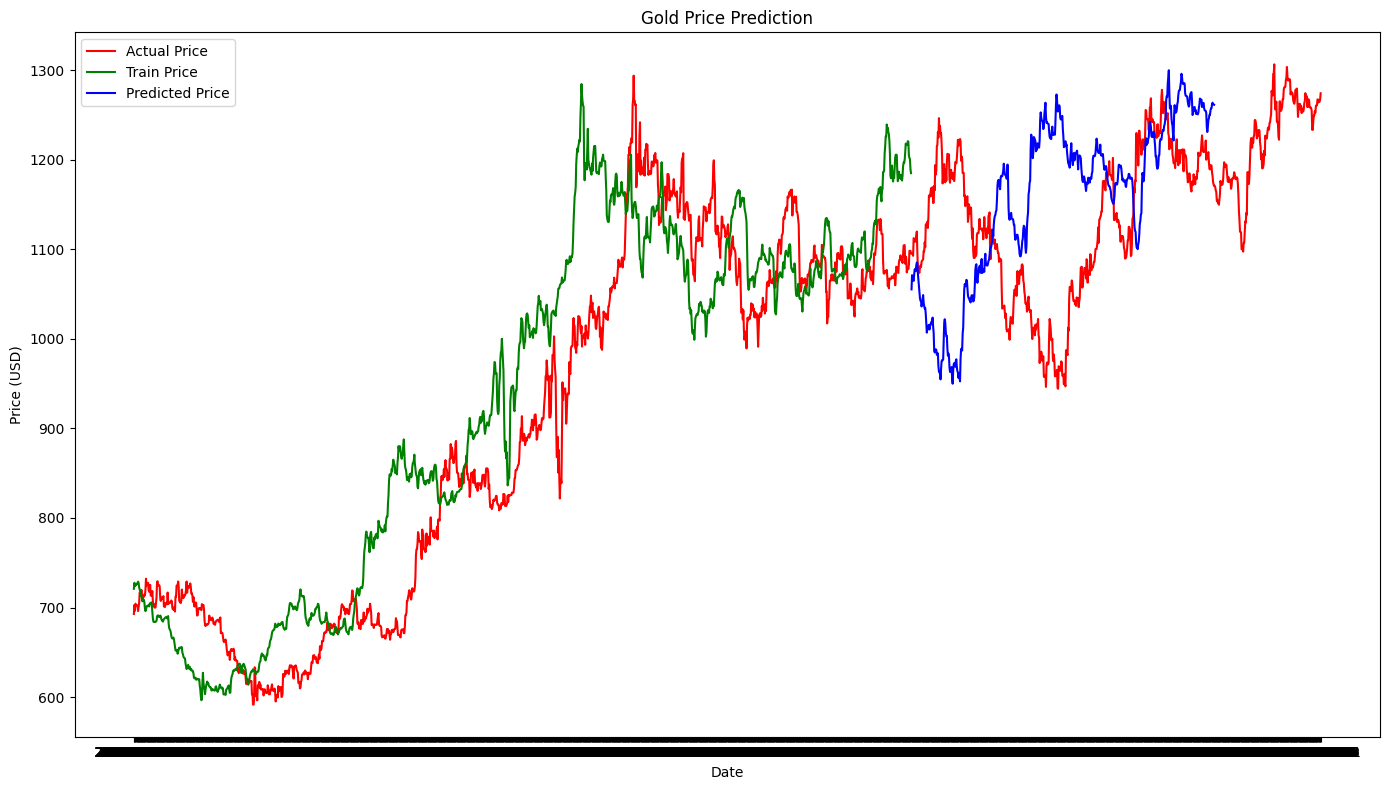

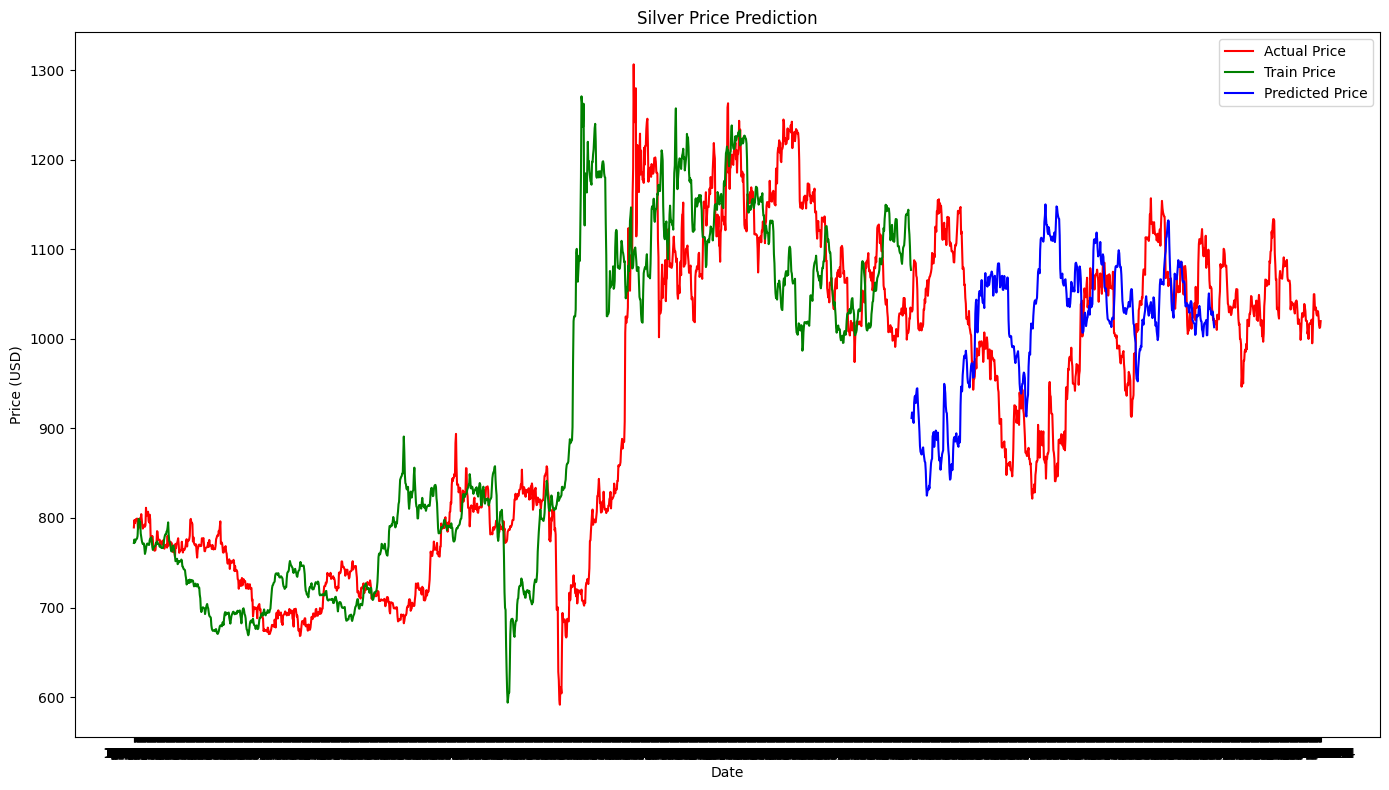

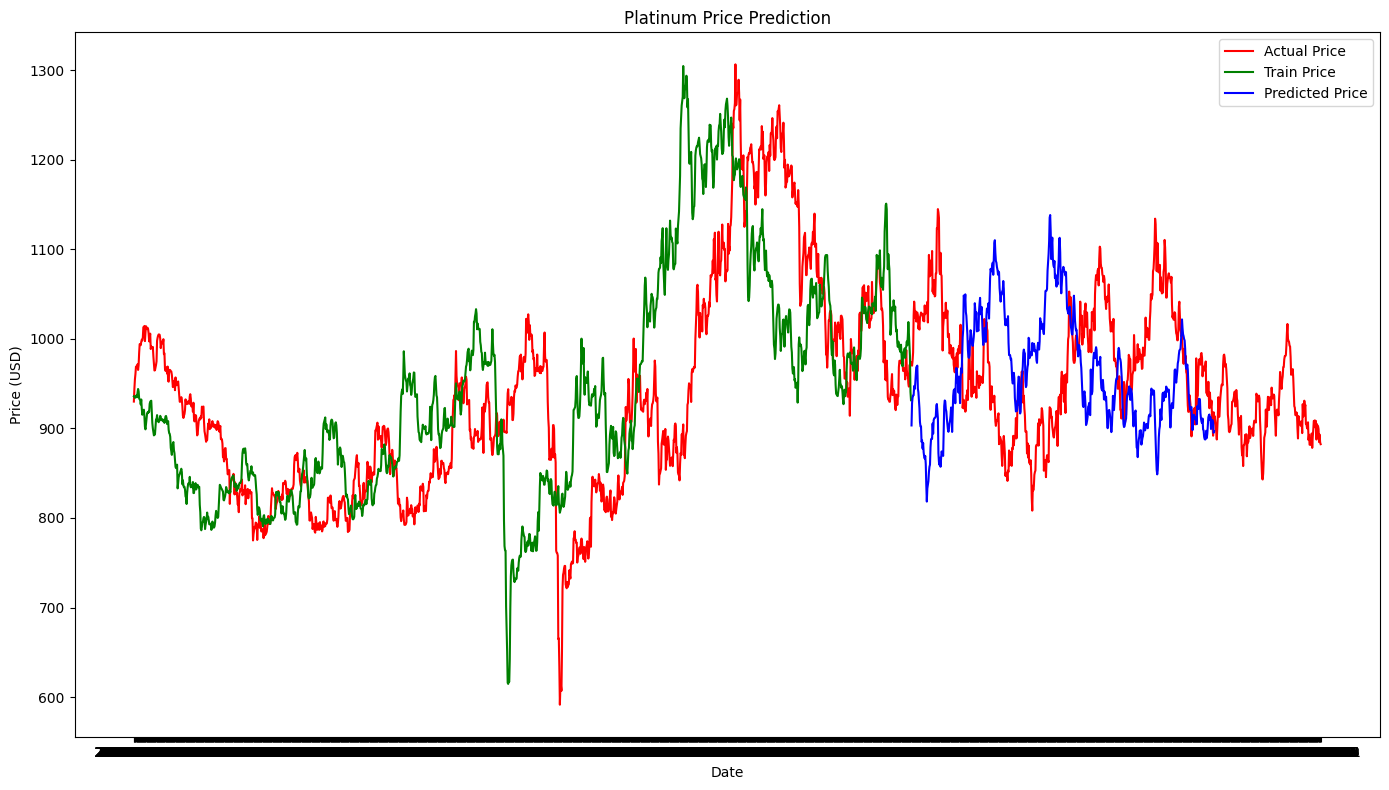

In [ ]:
# Prepare dates for plotting
dates_gold = df_gold['Date'].values
dates_silver = df_silver['Date'].values
dates_platinum = df_platinum['Date'].values

# Inverse transform to get actual values
train_gold_actual = scaler.inverse_transform(train_data_gold_part1)
test_gold_actual = scaler.inverse_transform(test_data_gold_part1)
train_silver_actual = scaler.inverse_transform(train_data_silver_part1)
test_silver_actual = scaler.inverse_transform(test_data_silver_part1)
train_platinum_actual = scaler.inverse_transform(train_data_platinum_part1)
test_platinum_actual = scaler.inverse_transform(test_data_platinum_part1)

# Combine train and test predictions for plotting
all_gold_actual = np.concatenate((train_gold_actual, test_gold_actual))
all_silver_actual = np.concatenate((train_silver_actual, test_silver_actual))
all_platinum_actual = np.concatenate((train_platinum_actual, test_platinum_actual))

# Plot results for gold dataset
plot_results(dates_gold[:len(all_gold_actual)], all_gold_actual, train_predict_gold, y_pred_gold, 'Gold Price Prediction')

# Plot results for silver dataset
plot_results(dates_silver[:len(all_silver_actual)], all_silver_actual, train_predict_silver, y_pred_silver, 'Silver Price Prediction')

# Plot results for platinum dataset
plot_results(dates_platinum[:len(all_platinum_actual)], all_platinum_actual, train_predict_platinum, y_pred_platinum, 'Platinum Price Prediction')

CHIA TỈ LỆ 8:2 - PART 2

In [10]:
#PART 2
time_step = 100
X_train_gold2, y_train_gold2 = create_dataset(train_data_gold_part2, time_step)
X_test_gold2, y_test_gold2 = create_dataset(test_data_gold_part2, time_step)

X_train_silver2, y_train_silver2 = create_dataset(train_data_silver_part2, time_step)
X_test_silver2, y_test_silver2 = create_dataset(test_data_silver_part2, time_step)

X_train_platinum2, y_train_platinum2 = create_dataset(train_data_platinum_part2, time_step)
X_test_platinum2, y_test_platinum2 = create_dataset(test_data_platinum_part2, time_step)


In [11]:
#PART 2
X_train_gold2 = X_train_gold2.reshape(X_train_gold2.shape[0], X_train_gold2.shape[1], 1)
X_test_gold2 = X_test_gold2.reshape(X_test_gold2.shape[0], X_test_gold2.shape[1], 1)

X_train_silver2 = X_train_silver2.reshape(X_train_silver2.shape[0], X_train_silver2.shape[1], 1)
X_test_silver2 = X_test_silver2.reshape(X_test_silver2.shape[0], X_test_silver2.shape[1], 1)

X_train_platinum2 = X_train_platinum2.reshape(X_train_platinum2.shape[0], X_train_platinum2.shape[1], 1)
X_test_platinum2 = X_test_platinum2.reshape(X_test_platinum2.shape[0], X_test_platinum2.shape[1], 1)


In [16]:
model_gold, history_gold = build_and_train_model(X_train_gold2, y_train_gold2, X_test_gold2, y_test_gold2)
model_silver, history_silver = build_and_train_model(X_train_silver2, y_train_silver2, X_test_silver2, y_test_silver2)
model_platinum, history_platinum = build_and_train_model(X_train_platinum2, y_train_platinum2, X_test_platinum2, y_test_platinum2)

Epoch 1/50
54/54 [==============================] - 9s 67ms/step - loss: 0.0124 - val_loss: 0.0017
Epoch 2/50
54/54 [==============================] - 3s 53ms/step - loss: 4.6634e-04 - val_loss: 3.2686e-04
Epoch 3/50
54/54 [==============================] - 7s 128ms/step - loss: 3.7324e-04 - val_loss: 3.1569e-04
Epoch 4/50
54/54 [==============================] - 7s 129ms/step - loss: 3.5472e-04 - val_loss: 2.8407e-04
Epoch 5/50
54/54 [==============================] - 6s 102ms/step - loss: 3.3882e-04 - val_loss: 2.6530e-04
Epoch 6/50
54/54 [==============================] - 8s 143ms/step - loss: 3.2539e-04 - val_loss: 3.3467e-04
Epoch 7/50
54/54 [==============================] - 6s 110ms/step - loss: 3.1097e-04 - val_loss: 2.5003e-04
Epoch 8/50
54/54 [==============================] - 7s 137ms/step - loss: 3.1015e-04 - val_loss: 2.9476e-04
Epoch 9/50
54/54 [==============================] - 5s 88ms/step - loss: 2.9700e-04 - val_loss: 2.7238e-04
Epoch 10/50
54/54 [====================

In [18]:
train_predict_gold, y_pred_gold = predict_and_evaluate(model_gold, X_train_gold2, X_test_gold2, scaler)
train_predict_silver, y_pred_silver = predict_and_evaluate(model_silver, X_train_silver2, X_test_silver2, scaler)
train_predict_platinum, y_pred_platinum = predict_and_evaluate(model_platinum, X_train_platinum2, X_test_platinum2, scaler)

11/11 [==============================] - 0s 13ms/step


In [19]:
#RMSE
test_rmse_gold = calculate_rmse(scaler.inverse_transform(y_test_gold2.reshape(-1, 1)), y_pred_gold)

test_rmse_silver = calculate_rmse(scaler.inverse_transform(y_test_silver2.reshape(-1, 1)), y_pred_silver)

test_rmse_platinum = calculate_rmse(scaler.inverse_transform(y_test_platinum2.reshape(-1, 1)), y_pred_platinum)

print('Gold RMSE:', test_rmse_gold)
print('Silver RMSE:', test_rmse_silver)
print('Platinum RMSE:', test_rmse_platinum)
print()

#MAE
mae_gold = calculate_mae(y_test_gold2, y_pred_gold)
mae_silver = calculate_mae(y_test_silver2, y_pred_silver)
mae_platinum = calculate_mae(y_test_platinum2, y_pred_platinum)

print('Gold MAE:', mae_gold)
print('Silver MAE:', mae_silver)
print('Platinum MAE:', mae_platinum)
print()
#MAPE
mape_gold = calculate_mape(y_test_gold2, y_pred_gold)
mape_silver = calculate_mape(y_test_silver2, y_pred_silver)
mape_platinum = calculate_mape(y_test_platinum2, y_pred_platinum)

print('Gold MAPE:', mape_gold)
print('Silver MAPE:', mape_silver)
print('Platinum MAPE:', mape_platinum)
print()


Gold RMSE: 11.291594475253106
Silver RMSE: 14.299149149804203
Platinum RMSE: 13.48495126327769

Gold MAE: 1223.754040334017
Silver MAE: 1046.0782075022519
Platinum MAE: 952.9585656166208

Gold MAPE: 140103.21710820697
Silver MAPE: 162804.39938343095
Platinum MAPE: 193287.81976437307



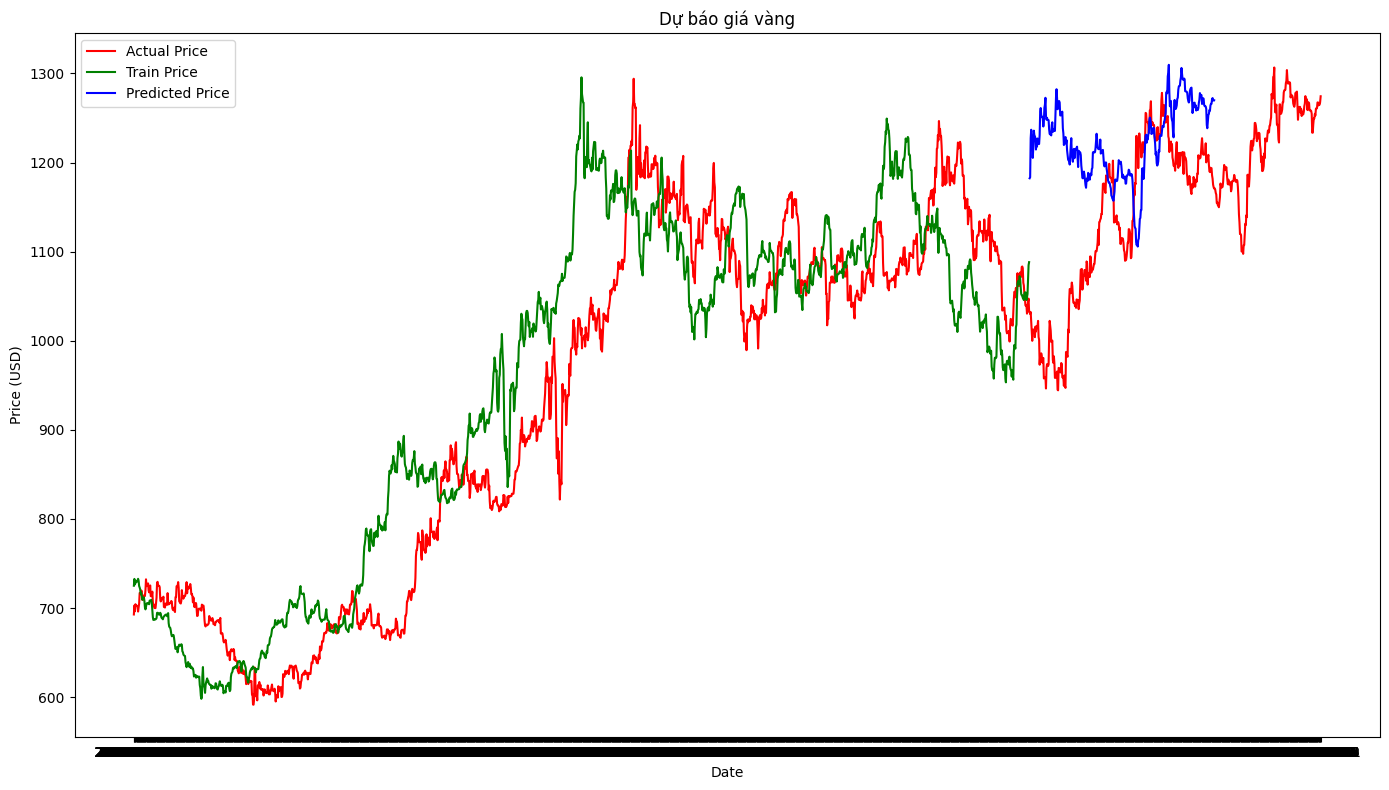

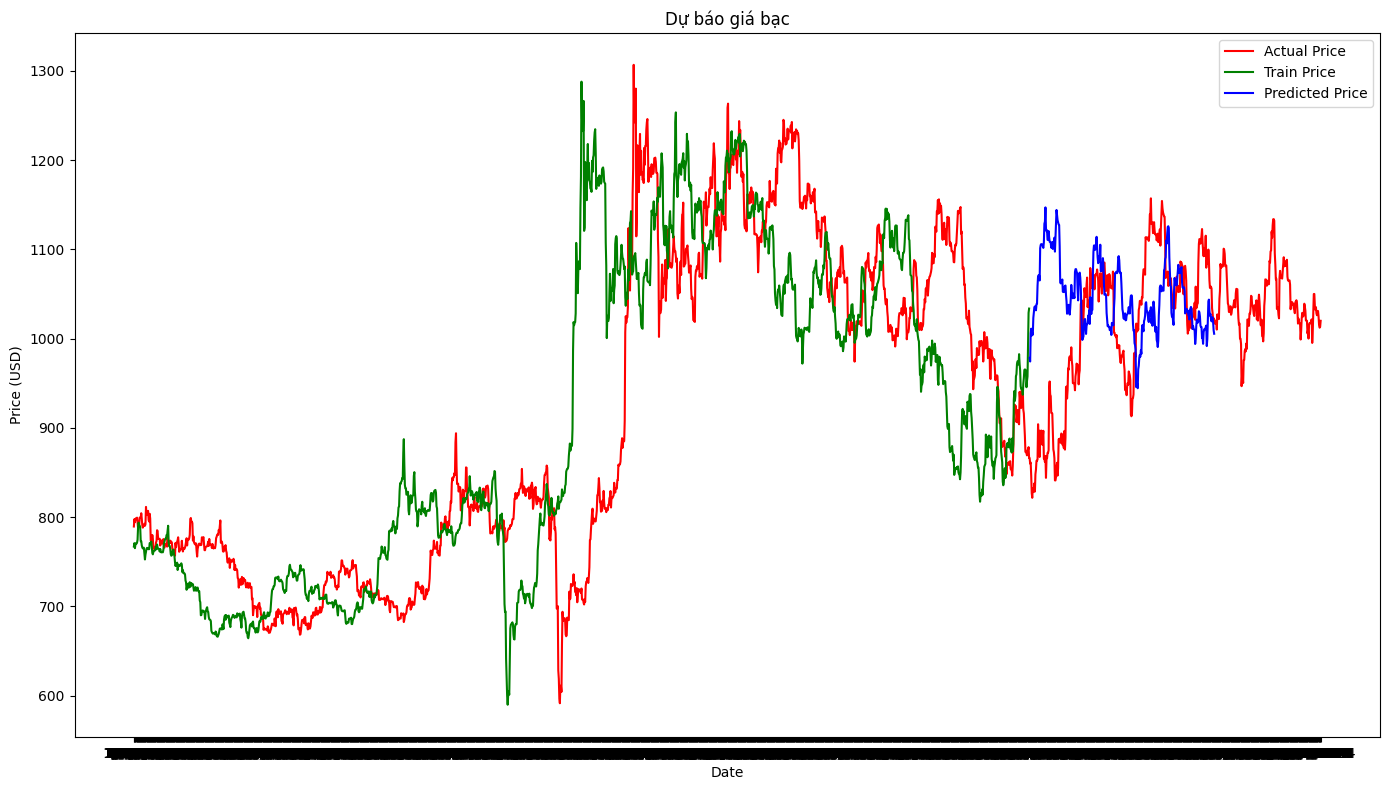

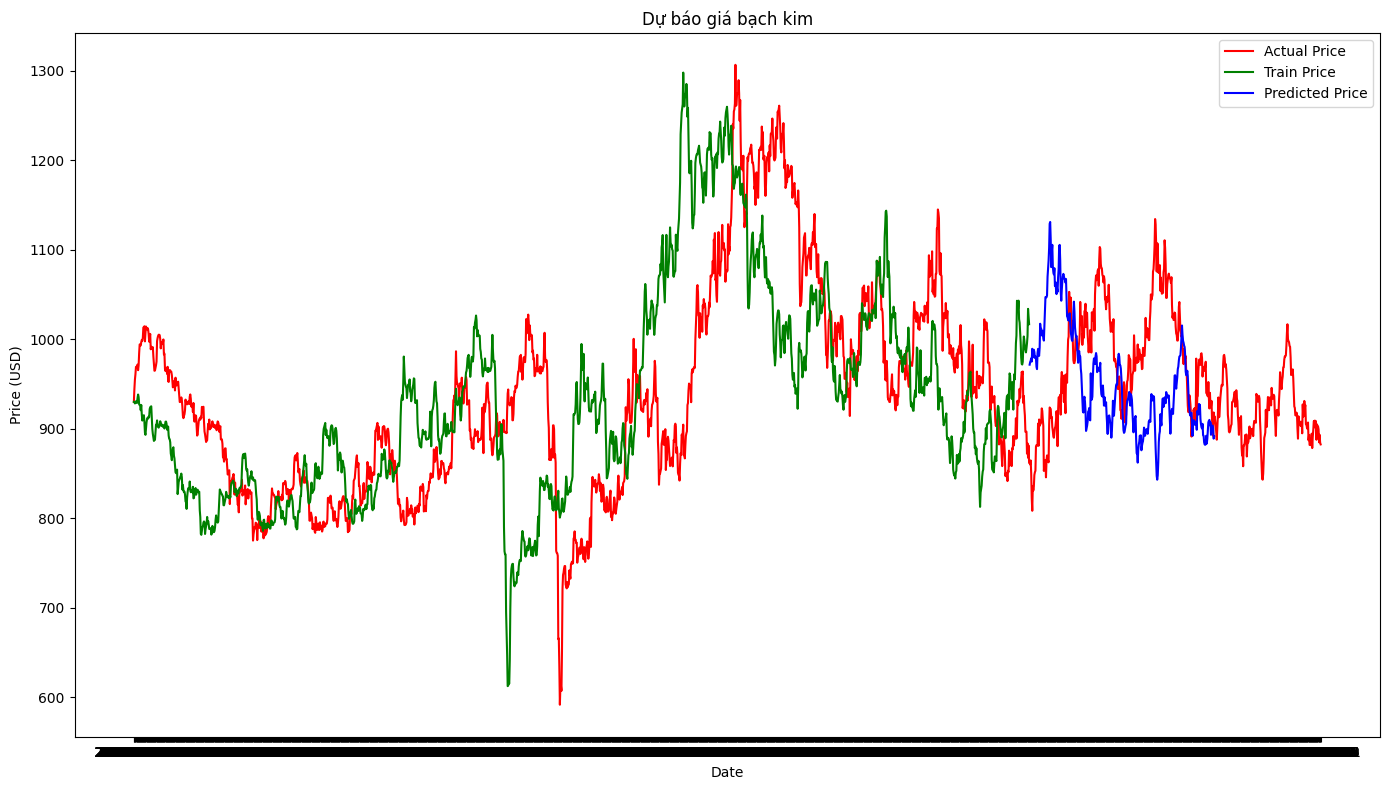

In [20]:
# Prepare dates for plotting
dates_gold = df_gold['Date'].values
dates_silver = df_silver['Date'].values
dates_platinum = df_platinum['Date'].values

# Inverse transform to get actual values
train_gold_actual = scaler.inverse_transform(train_data_gold_part2)
test_gold_actual = scaler.inverse_transform(test_data_gold_part2)
train_silver_actual = scaler.inverse_transform(train_data_silver_part2)
test_silver_actual = scaler.inverse_transform(test_data_silver_part2)
train_platinum_actual = scaler.inverse_transform(train_data_platinum_part2)
test_platinum_actual = scaler.inverse_transform(test_data_platinum_part2)

# Combine train and test predictions for plotting
all_gold_actual = np.concatenate((train_gold_actual, test_gold_actual))
all_silver_actual = np.concatenate((train_silver_actual, test_silver_actual))
all_platinum_actual = np.concatenate((train_platinum_actual, test_platinum_actual))

# Plot results for gold dataset
plot_results(dates_gold[:len(all_gold_actual)], all_gold_actual, train_predict_gold, y_pred_gold, 'Dự báo giá vàng')

# Plot results for silver dataset
plot_results(dates_silver[:len(all_silver_actual)], all_silver_actual, train_predict_silver, y_pred_silver, 'Dự báo giá bạc')

# Plot results for platinum dataset
plot_results(dates_platinum[:len(all_platinum_actual)], all_platinum_actual, train_predict_platinum, y_pred_platinum, 'Dự báo giá bạch kim')

CHIA TỈ LỆ 9:1 - PART 3

In [21]:
#PART 3
X_train_gold3, y_train_gold3 = create_dataset(train_data_gold_part3, time_step)
X_test_gold3, y_test_gold3 = create_dataset(test_data_gold_part3, time_step)

X_train_silver3, y_train_silver3 = create_dataset(train_data_silver_part3, time_step)
X_test_silver3, y_test_silver3 = create_dataset(test_data_silver_part3, time_step)

X_train_platinum3, y_train_platinum3 = create_dataset(train_data_platinum_part3, time_step)
X_test_platinum3, y_test_platinum3 = create_dataset(test_data_platinum_part3, time_step)

In [22]:
#PART 3
X_train_gold3 = X_train_gold3.reshape(X_train_gold3.shape[0], X_train_gold3.shape[1], 1)
X_test_gold3 = X_test_gold3.reshape(X_test_gold3.shape[0], X_test_gold3.shape[1], 1)

X_train_silver3 = X_train_silver3.reshape(X_train_silver3.shape[0], X_train_silver3.shape[1], 1)
X_test_silver3 = X_test_silver3.reshape(X_test_silver3.shape[0], X_test_silver3.shape[1], 1)

X_train_platinum3 = X_train_platinum3.reshape(X_train_platinum3.shape[0], X_train_platinum3.shape[1], 1)
X_test_platinum3 = X_test_platinum3.reshape(X_test_platinum3.shape[0], X_test_platinum3.shape[1], 1)

In [23]:
model_gold, history_gold = build_and_train_model(X_train_gold3, y_train_gold3, X_test_gold3, y_test_gold3)
model_silver, history_silver = build_and_train_model(X_train_silver3, y_train_silver3, X_test_silver3, y_test_silver3)
model_platinum, history_platinum = build_and_train_model(X_train_platinum3, y_train_platinum3, X_test_platinum3, y_test_platinum3)

Epoch 1/50
61/61 [==============================] - 7s 57ms/step - loss: 0.0610 - val_loss: 0.0018
Epoch 2/50
61/61 [==============================] - 3s 46ms/step - loss: 0.0021 - val_loss: 4.1506e-04
Epoch 3/50
61/61 [==============================] - 3s 54ms/step - loss: 5.3770e-04 - val_loss: 3.6119e-04
Epoch 4/50
61/61 [==============================] - 5s 80ms/step - loss: 4.9748e-04 - val_loss: 3.6154e-04
Epoch 5/50
61/61 [==============================] - 3s 48ms/step - loss: 4.7037e-04 - val_loss: 3.0868e-04
Epoch 6/50
61/61 [==============================] - 3s 49ms/step - loss: 4.4116e-04 - val_loss: 2.9763e-04
Epoch 7/50
61/61 [==============================] - 3s 48ms/step - loss: 4.1656e-04 - val_loss: 2.8030e-04
Epoch 8/50
61/61 [==============================] - 4s 69ms/step - loss: 3.9900e-04 - val_loss: 3.1017e-04
Epoch 9/50
61/61 [==============================] - 4s 63ms/step - loss: 3.8886e-04 - val_loss: 3.0921e-04
Epoch 10/50
61/61 [==============================

In [24]:
train_predict_gold, y_pred_gold = predict_and_evaluate(model_gold, X_train_gold3, X_test_gold3, scaler)
train_predict_silver, y_pred_silver = predict_and_evaluate(model_silver, X_train_silver3, X_test_silver3, scaler)
train_predict_platinum, y_pred_platinum = predict_and_evaluate(model_platinum, X_train_platinum3, X_test_platinum3, scaler)

4/4 [==============================] - 0s 13ms/step


In [25]:
#RMSE
test_rmse_gold = calculate_rmse(scaler.inverse_transform(y_test_gold3.reshape(-1, 1)), y_pred_gold)

test_rmse_silver = calculate_rmse(scaler.inverse_transform(y_test_silver3.reshape(-1, 1)), y_pred_silver)

test_rmse_platinum = calculate_rmse(scaler.inverse_transform(y_test_platinum3.reshape(-1, 1)), y_pred_platinum)

print('Gold RMSE:', test_rmse_gold)
print('Silver RMSE:', test_rmse_silver)
print('Platinum RMSE:', test_rmse_platinum)
print()

#MAE
mae_gold = calculate_mae(y_test_gold3, y_pred_gold)
mae_silver = calculate_mae(y_test_silver3, y_pred_silver)
mae_platinum = calculate_mae(y_test_platinum3, y_pred_platinum)

print('Gold MAE:', mae_gold)
print('Silver MAE:', mae_silver)
print('Platinum MAE:', mae_platinum)
print()
#MAPE
mape_gold = calculate_mape(y_test_gold3, y_pred_gold)
mape_silver = calculate_mape(y_test_silver3, y_pred_silver)
mape_platinum = calculate_mape(y_test_platinum3, y_pred_platinum)

print('Gold MAPE:', mape_gold)
print('Silver MAPE:', mape_silver)
print('Platinum MAPE:', mape_platinum)
print()



Gold RMSE: 9.93370182845481
Silver RMSE: 11.634383658145824
Platinum RMSE: 11.747939748862832

Gold MAE: 1256.3131463227382
Silver MAE: 1046.5682154449557
Platinum MAE: 920.1087737268783

Gold MAPE: 135519.70350459416
Silver MAPE: 165715.58455321114
Platinum MAPE: 200834.30373746247



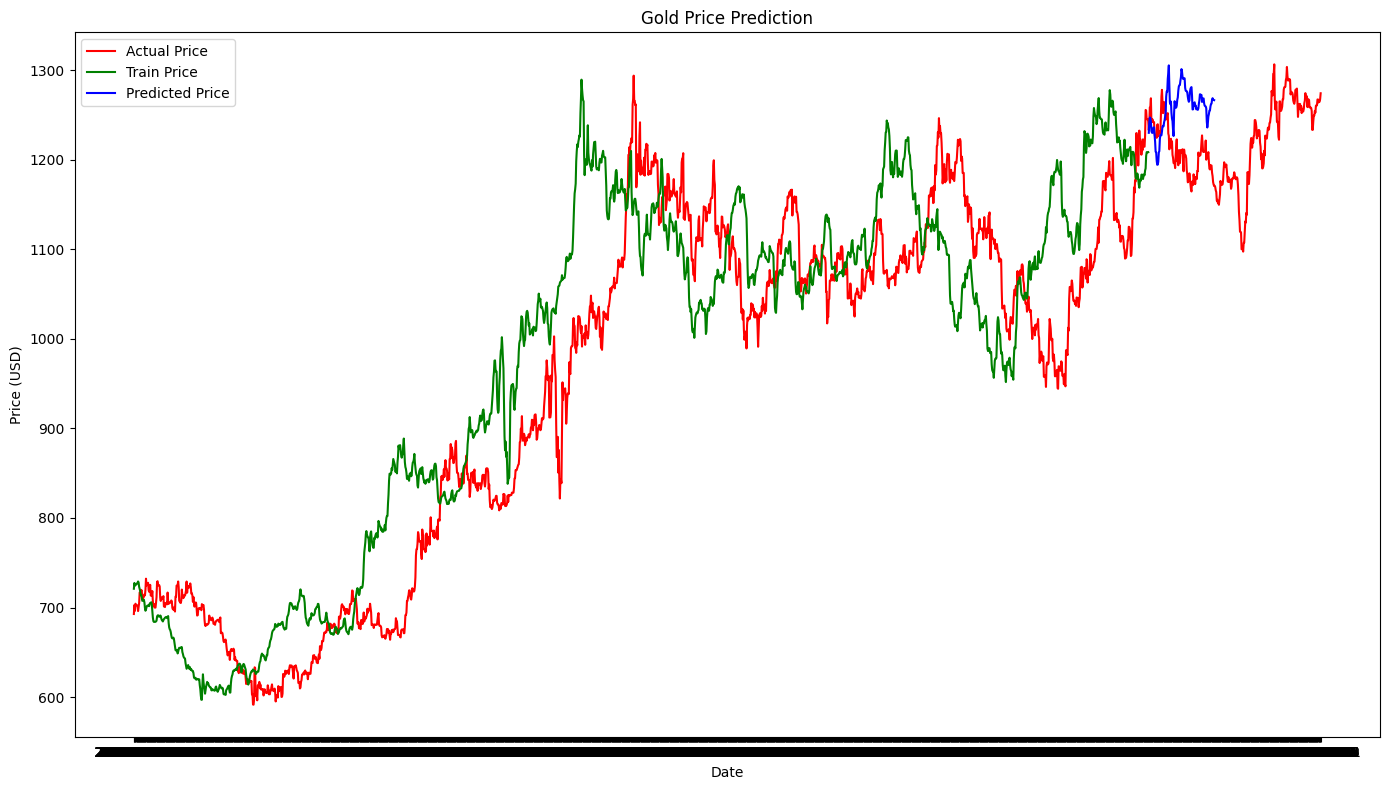

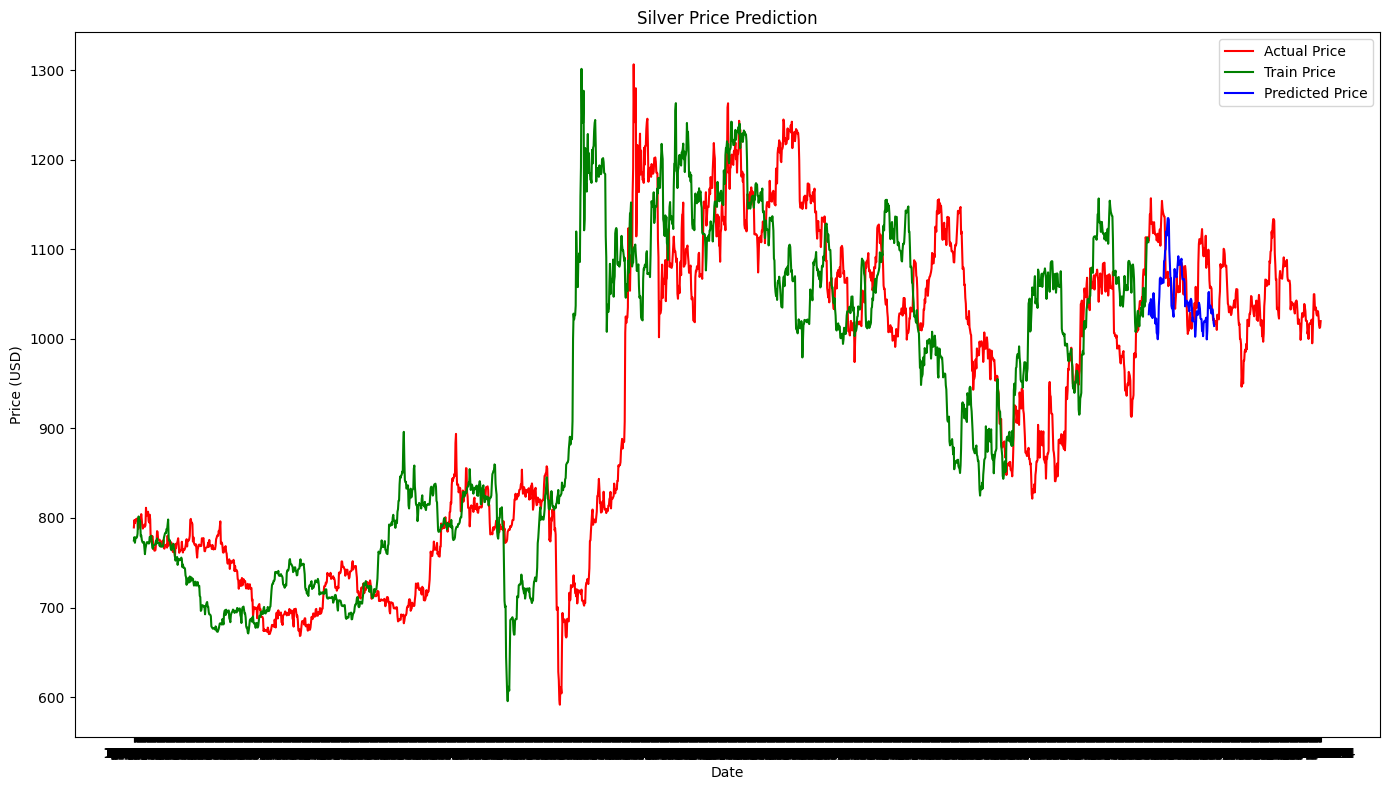

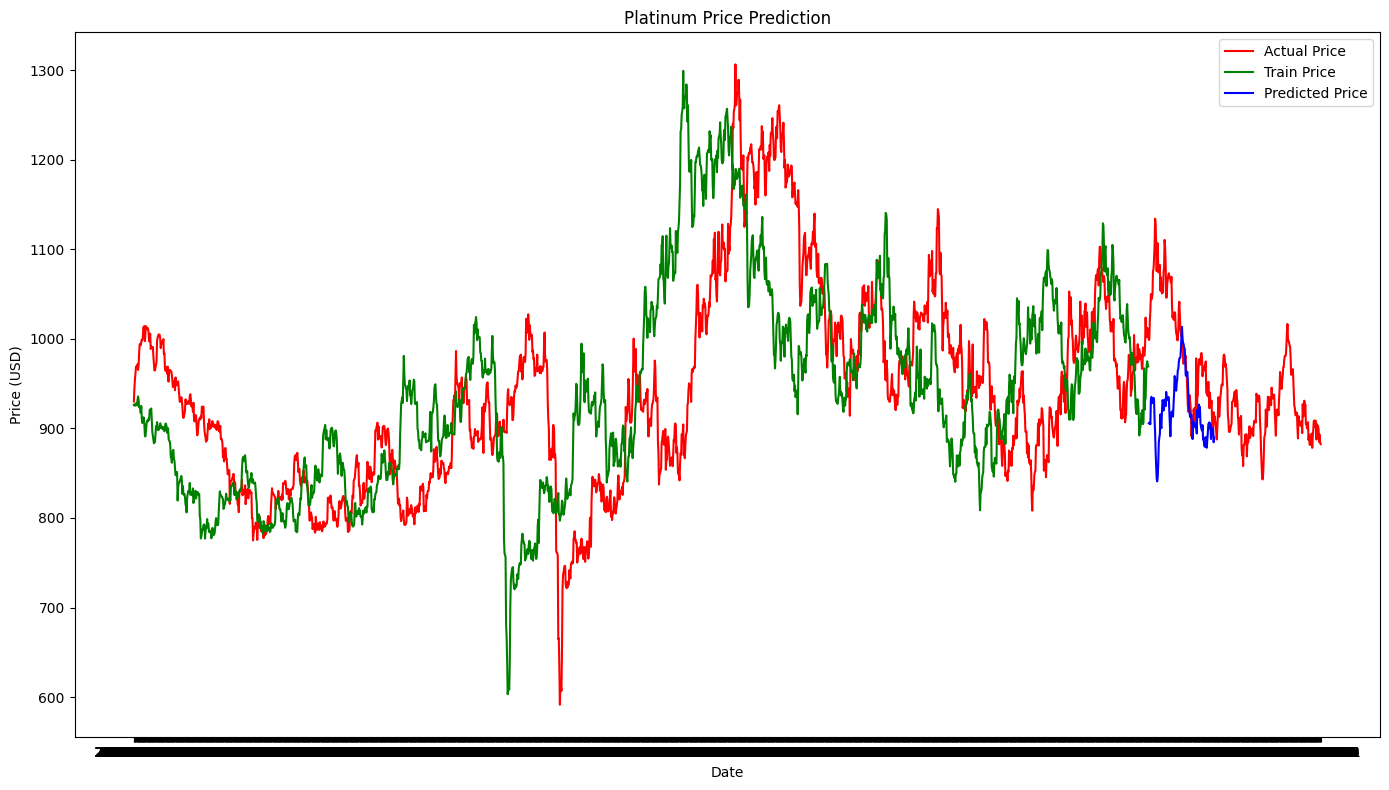

In [26]:
# Prepare dates for plotting
dates_gold = df_gold['Date'].values
dates_silver = df_silver['Date'].values
dates_platinum = df_platinum['Date'].values

# Inverse transform to get actual values
train_gold_actual = scaler.inverse_transform(train_data_gold_part3)
test_gold_actual = scaler.inverse_transform(test_data_gold_part3)
train_silver_actual = scaler.inverse_transform(train_data_silver_part3)
test_silver_actual = scaler.inverse_transform(test_data_silver_part3)
train_platinum_actual = scaler.inverse_transform(train_data_platinum_part3)
test_platinum_actual = scaler.inverse_transform(test_data_platinum_part3)

# Combine train and test predictions for plotting
all_gold_actual = np.concatenate((train_gold_actual, test_gold_actual))
all_silver_actual = np.concatenate((train_silver_actual, test_silver_actual))
all_platinum_actual = np.concatenate((train_platinum_actual, test_platinum_actual))

# Plot results for gold dataset
plot_results(dates_gold[:len(all_gold_actual)], all_gold_actual, train_predict_gold, y_pred_gold, 'Gold Price Prediction')

# Plot results for silver dataset
plot_results(dates_silver[:len(all_silver_actual)], all_silver_actual, train_predict_silver, y_pred_silver, 'Silver Price Prediction')

# Plot results for platinum dataset
plot_results(dates_platinum[:len(all_platinum_actual)], all_platinum_actual, train_predict_platinum, y_pred_platinum, 'Platinum Price Prediction')